# A Journey into sound

In [1]:
from IPython.display import Audio, display
display(Audio(filename="../ESC-50/train/1-100032-A-0.wav"))

In [ ]:
import librosa
import matplotlib.pyplot as plt
from pathlib import Path 
import numpy as np



In [2]:
# last char in file name is the class
import glob
from collections import Counter 
esc50_list = [f.split("-")[-1].replace(".wav", "")
              for f in glob.glob("../ESC-50/audio/*.wav")]
Counter(esc50_list)

Counter()

In [3]:
from torch.utils.data import Dataset 
import torchaudio
import torch
import warnings
warnings.filterwarnings(
    "ignore",
    message=r"In 2\.9, this function's implementation will be changed to use torchaudio\.load_with_torchcodec",
    category=UserWarning,
)


class ESC50(Dataset):
    def __init__(self, path):
        files = Path(path).glob("*.wav")
        # items: list of (filename, class)
        self.items = [(f, int(f.name.split("-")[-1].replace(".wav",""))) 
                      for f in files]
        self.length = len(self.items)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        filename, label = self.items[index]
        audio_tensor, sample_rate = torchaudio.load(filename)
        return audio_tensor, label # audio_tensor: [1,time]
        

In [4]:
test_esc50 = ESC50("../ESC-50/train")
tensor, label = list(test_esc50)[0]
print(tensor)
print(tensor.shape)
print(label)

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([1, 220500])
0


In [5]:
example_loader = torch.utils.data.DataLoader(test_esc50, batch_size=64, shuffle=True)

In [6]:
bs = 64 
device = "cuda" if torch.cuda.is_available() else "cpu" 

PATH_TO_ESC50 = Path.cwd() / ".." / "ESC-50"
train_esc50 = ESC50(PATH_TO_ESC50 / "train")
valid_esc50 = ESC50(PATH_TO_ESC50 / "valid")
test_esc50 = ESC50(PATH_TO_ESC50 / "test")

train_loader = torch.utils.data.DataLoader(train_esc50, batch_size=bs, shuffle=True, num_workers=0, pin_memory=(device=="cuda"))
valid_loader = torch.utils.data.DataLoader(valid_esc50, batch_size=bs, shuffle=False, num_workers=0, pin_memory=(device=="cuda"))
test_loader = torch.utils.data.DataLoader(test_esc50, batch_size=bs, shuffle=False, num_workers=0, pin_memory=(device=="cuda"))

In [7]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim 

class AudioNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # (in_channels, out_channels, kernel, stride)
        self.conv1 = nn.Conv1d(1, 128, 80, 4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4) # kernel_size=4

        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)

        self.conv3 = nn.Conv1d(128, 256, 3) # conv3: (batch,256,time) 
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)

        self.conv4 = nn.Conv1d(256, 512, 3)# conv4: (batch,512,time)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)

        self.avgPool = nn.AdaptiveAvgPool1d(1) # (batch,512,time)
        self.fc1 = nn.Linear(512,num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)

        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)

        x = self.avgPool(x).squeeze(-1) # (batch,512)
        logits = self.fc1(x) # (batch,classes)
        return logits

def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-7, final_value=10, device="cpu"):
    model.train()
    num_batches = len(train_loader)-1
    if num_batches <= 0:
        raise ValueError("Need at least 2 batches for LR finder.")
    mult = (final_value / init_value) ** (1/num_batches)
    lr = init_value 
    for pg in optimizer.param_groups:
        pg["lr"] = lr
    best_loss = float("inf")
    batch_idx = 0
    lrs, losses = [], []
    for inputs, targets in train_loader:
        batch_idx += 1
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True).long()
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss_val = float(loss.item())
        lrs.append(lr)
        losses.append(loss_val)
        if loss_val<best_loss:
            best_loss = loss_val
        # stop if exploding
        if batch_idx > 1 and loss_val > best_loss * 4:
            break

        loss.backward()
        optimizer.step() 
        
        # KEY: changing learning-rate here
        lr *= mult 
        for pg in optimizer.param_groups:
            pg["lr"]= lr
            
        if lr > final_value or batch_idx >= len(train_loader):
            break 
    # trim a bit from both ends for nicer plot
    if len(lrs) > 20:
        return lrs[10:-5], losses[10:-5]
    return lrs, losses
        


In [8]:
@torch.no_grad()
def evaluate(model, loss_fn, loader, device):
    model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0 
    for inputs, targets in loader:
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True).long()
        logits = model(inputs)
        loss = loss_fn(logits, targets)
        total_loss += float(loss.item()) * inputs.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds==targets).sum().item()
        total_count += inputs.size(0)
    return total_loss / max(1, total_count), total_correct / max(1, total_count)



In [9]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, device):
    for epoch in range(1, epochs+1):
        model.train()
        run_loss = 0.0
        seen = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True).long()
            optimizer.zero_grad(set_to_none=True)
            logits = model(inputs)
            loss = loss_fn(logits, targets)
            loss.backward()
            optimizer.step()
            run_loss += float(loss.item()) * inputs.size(0)
            seen += inputs.size(0)
        train_loss = run_loss / max(1,seen)
        val_loss, val_acc = evaluate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch:03d} | train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | val_acc {val_acc:.4f}")

### LR Finder

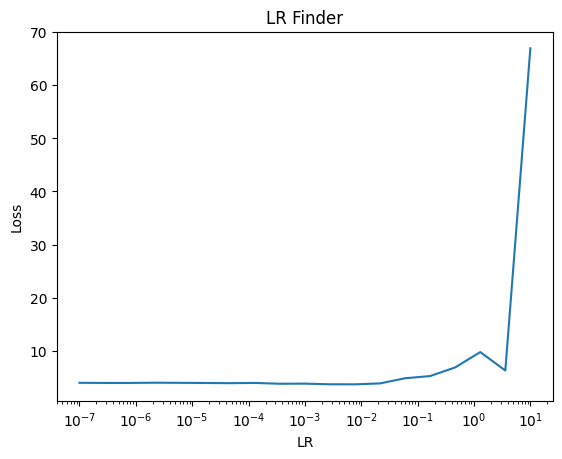

In [10]:
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu" 
audio_net = AudioNet(num_classes=50).to(device)
criterion = nn.CrossEntropyLoss()
lr_opt = optim.Adam(audio_net.parameters(), lr=1e-7, weight_decay=1e-4)
lrs, losses = find_lr(audio_net, criterion, lr_opt, train_loader, device=device)

plt.figure()
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("LR")
plt.ylabel("Loss")
plt.title("LR Finder")
plt.show()

### Train

In [11]:
EPOCHS = 30
optimizer = optim.Adam(audio_net.parameters(), lr=1e-5)
train(audio_net, optimizer, criterion, train_loader, valid_loader, EPOCHS, device)

Epoch 001 | train_loss 78.3644 | val_loss 112.2036 | val_acc 0.0150
Epoch 002 | train_loss 77.9673 | val_loss 62.4241 | val_acc 0.0150
Epoch 003 | train_loss 76.8645 | val_loss 68.8177 | val_acc 0.0150
Epoch 004 | train_loss 79.8242 | val_loss 62.9956 | val_acc 0.0125
Epoch 005 | train_loss 77.0018 | val_loss 64.3288 | val_acc 0.0150
Epoch 006 | train_loss 76.9408 | val_loss 64.0261 | val_acc 0.0150
Epoch 007 | train_loss 78.5664 | val_loss 64.6491 | val_acc 0.0125
Epoch 008 | train_loss 76.0191 | val_loss 59.2437 | val_acc 0.0150
Epoch 009 | train_loss 77.0385 | val_loss 60.2633 | val_acc 0.0150
Epoch 010 | train_loss 75.3718 | val_loss 63.1726 | val_acc 0.0150
Epoch 011 | train_loss 76.5196 | val_loss 65.9950 | val_acc 0.0150
Epoch 012 | train_loss 75.5313 | val_loss 61.0077 | val_acc 0.0125
Epoch 013 | train_loss 78.4623 | val_loss 60.5782 | val_acc 0.0125
Epoch 014 | train_loss 75.9991 | val_loss 60.4227 | val_acc 0.0125
Epoch 015 | train_loss 75.6688 | val_loss 61.0790 | val_acc 0

In [12]:
test_loss, test_acc = evaluate(audio_net, criterion, test_loader, device)
print(f"Test | loss {test_loss:.4f} | acc {test_acc:.4f}")
torch.save(audio_net.state_dict(), "audionet.pth")

Test | loss 91.0709 | acc 0.0175


## Mel Spectrogram

In [13]:
import numpy as np

sample_data, sr = librosa.load("../ESC-50/train/1-100032-A-0.wav", sr=None)

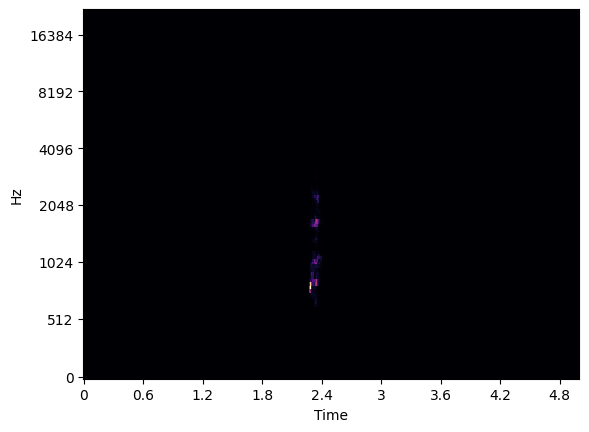

In [14]:
spectrogram = librosa.feature.melspectrogram(y=sample_data, sr=sr)
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel')

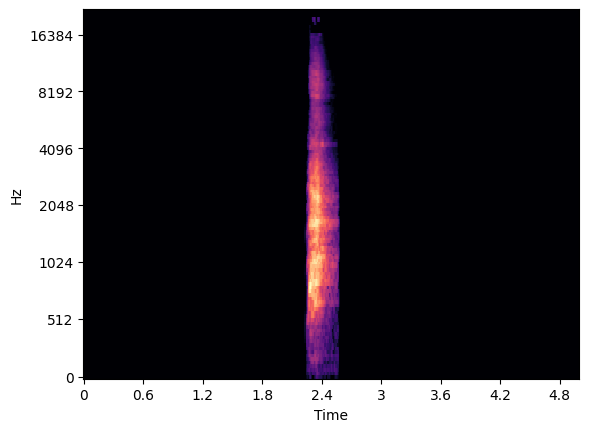

In [15]:
# compute a scaling factor = 10*log10(spectrogram/ref)
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
librosa.display.specshow(log_spectrogram, sr=sr, x_axis="time", y_axis="mel")

In [16]:
log_spectrogram.shape


(128, 431)

In [20]:
import functools
import torchvision

class ESC50Spectrogram(Dataset):
    def __init__(self, path):
        files = Path(path).glob("*.wav")
        # list of ('test.wav', 4), ...
        self.items = [(f, int(f.name.split("-")[-1].replace(".wav", "")))
            for f in files]
        self.length = len(self.items)
        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor()])

    # set Least Recently Used (LRU) cache
    @functools.lru_cache(maxsize=None)
    def __getitem__(self, index):
        filename, label = self.items[index]
        audio_tensor, sample_rate = librosa.load(filename, sr=None)
        spectrogram = librosa.feature.melspectrogram(y=audio_tensor, sr=sample_rate)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

        fig = plt.figure(figsize=(3,3))
        librosa.display.specshow(log_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
        fig.canvas.draw()
        audio_data = np.asarray(fig.canvas.buffer_rgba())[:,:,:3]
        audio_data = audio_data.reshape(fig.canvas.get_width_height()[::-1] + (3,)) # (width,height)=>(height,width)=>(height,width,3)
        plt.close(fig)
        return (self.transforms(audio_data), label)
        
    def __len__(self):
        return self.length

In [21]:
import time

oldESC50 = ESC50("../ESC-50/train/")
start_time = time.process_time()
oldESC50.__getitem__(33)
end_time = time.process_time()
old_time = end_time - start_time 
old_time


0.0

In [22]:
newESC50 = ESC50Spectrogram("../ESC-50/train/")
start_time = time.process_time()
newESC50.__getitem__(33)
end_time = time.process_time()
new_time = end_time - start_time
new_time

0.28125

In [ ]:
def precompute_spectrograms(path, dpi=50):
    files = Path(path).glob("*.wav")
    outdir = Path(path) / "spectrograms"
    outdir.mkdir(parents=True, exist_ok=True)
    
    for filename in files:
        path_saved = outdir / f"{filename.stem}_{dpi}.png"
        # Skip if file already exists
        if path_saved.exists():
            print("Skip:", path_saved)
            continue
            
        audio_tensor, sample_rate = librosa.load(filename, sr=None)
        spectrogram = librosa.feature.melspectrogram(y=audio_tensor, sr=sample_rate)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        librosa.display.specshow(log_spectrogram, sr=sample_rate, x_axis="time", y_axis="mel")
        
        plt.savefig(path_saved, dpi=dpi)
        print("Saved:", path_saved)
precompute_spectrograms("../ESC-50/train")
precompute_spectrograms("../ESC-50/valid")
precompute_spectrograms("../ESC-50/test")
